In [36]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [37]:
df = pd.read_csv('alzheimers_disease_data.csv', sep=',')
df = df.drop(columns=['PatientID', 'DoctorInCharge'])

In [38]:
df_majority = df[df.Diagnosis == 0]
df_minority = df[df.Diagnosis == 1]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # Échantillonnage sans remplacement
                                   n_samples=len(df_minority),     # Pour obtenir le même nombre de samples que la classe minoritaire
                                   random_state=0) # Pour reproduire les résultats

df_balanced = pd.concat([df_majority_downsampled, df_minority])

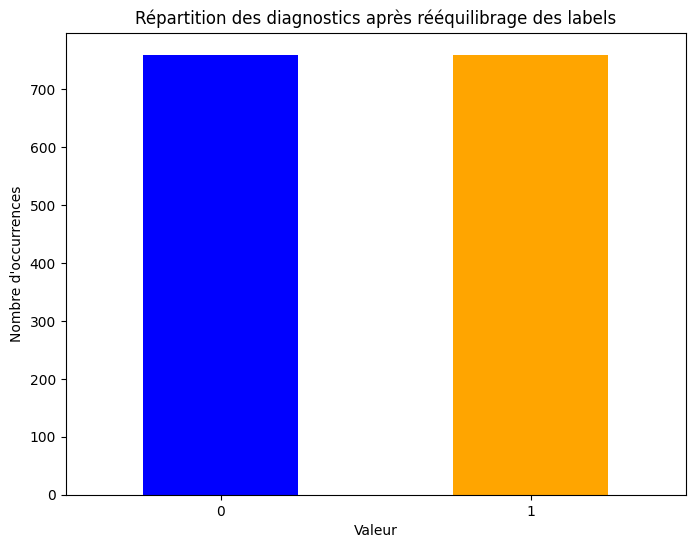

In [39]:
# Compter les occurrences de chaque valeur
value_counts = df_balanced['Diagnosis'].value_counts()

# Créer le graphique à barres
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Répartition des diagnostics après rééquilibrage des labels')
plt.xlabel('Valeur')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=0)
plt.show()

In [40]:
# Définir les pipelines pour différents modèles
pipelines = {
    'logistic_regression_standard': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression())
    ]),
    'logistic_regression_minmax': Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', LogisticRegression())
    ]),
    'decision_tree': Pipeline([
        ('classifier', DecisionTreeClassifier())
    ]),
    'random_forest': Pipeline([
        ('classifier', RandomForestClassifier())
    ]),
    'gradient_boosting': Pipeline([
        ('classifier', GradientBoostingClassifier())
    ]),
    'svm_standard': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC())
    ]),
    'svm_minmax': Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', SVC())
    ]),
    'knn_standard': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier())
    ]),
    'knn_minmax': Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', KNeighborsClassifier())
    ]),
    'naive_bayes_standard': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GaussianNB())
    ]),
    'naive_bayes_minmax': Pipeline([
        ('scaler', MinMaxScaler()),
        ('classifier', GaussianNB())
    ]),
}

'''
Best pipeline: DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=5, min_samples_leaf=8, min_samples_split=2)
'''

# Définir les grilles de paramètres pour chaque modèle
param_grids = {
    'logistic_regression_standard': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'elasticnet', 'l2'],
        'classifier__solver': ['lbfgs', 'saga'],
        'classifier__max_iter': [100, 200, 300]
    },
    'logistic_regression_minmax': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'elasticnet', 'l2'],
        'classifier__solver': ['lbfgs', 'saga'],
        'classifier__max_iter': [100, 200, 300]
    },
    'decision_tree': {
        'classifier__max_depth': [5, 10, 20, 30, 40],
        'classifier__min_samples_split': [2, 5, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 5],
        'classifier__criterion': ['gini', 'entropy']
    },
    'random_forest': {
        'classifier__n_estimators': [50, 100, 200, 500],
        'classifier__max_depth': [5, 10, 20, 30, 40],
        'classifier__min_samples_split': [2, 5, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 5],
        'classifier__bootstrap': [True, False]
    },
    'gradient_boosting': {
        'classifier__n_estimators': [50, 100, 200, 500],
        'classifier__learning_rate': [0.001, 0.01, 0.1, 0.5],
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__subsample': [0.6, 0.8, 1.0]
    },
    'svm_standard': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf', 'poly'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__degree': [3, 4, 5]  # applicable for 'poly' kernel
    },
    'svm_minmax': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf', 'poly'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__degree': [3, 4, 5]
    },
    'knn_standard': {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]  # p=1 for Manhattan, p=2 for Euclidean distance
    },
    'knn_minmax': {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    },
    'naive_bayes_standard': {
        'classifier__var_smoothing': [1e-10, 1e-09, 1e-08, 1e-07]
    },
    'naive_bayes_minmax': {
        'classifier__var_smoothing': [1e-10, 1e-09, 1e-08, 1e-07]
    },
}


def generetate_models(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, folder: str):
    # Effectuer la recherche par grille pour chaque modèle
    best_models = {}
    for model_name in pipelines:
        print(f'Optimizing {model_name}...')
        grid_search = GridSearchCV(pipelines[model_name], param_grids[model_name], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f'Best parameters for {model_name}: {grid_search.best_params_}')
        print(f'Best score for {model_name}: {grid_search.best_score_}')

    # Évaluer les meilleurs modèles sur le set de test
    for model_name, model in best_models.items():
        y_pred = model.predict(X_test)
        print(f'\nModel: {model_name}')
        joblib.dump(model, '{}/{}.joblib'.format(folder, model_name))
        print('Accuracy:', accuracy_score(y_test, y_pred))
        print('Classification Report:')
        print(classification_report(y_test, y_pred))

In [41]:
y = df_balanced.Diagnosis
X = df_balanced.drop(columns=['Diagnosis'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
generetate_models(X_train, y_train, X_test, y_test, 'all_columns')

Optimizing logistic_regression_standard...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheim

Best parameters for logistic_regression_standard: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best score for logistic_regression_standard: 0.8297578088106322
Optimizing logistic_regression_minmax...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheim

Best parameters for logistic_regression_minmax: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best score for logistic_regression_minmax: 0.8363387978142077
Optimizing decision_tree...
Best parameters for decision_tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Best score for decision_tree: 0.9317547055251973
Optimizing random_forest...
Best parameters for random_forest: {'classifier__bootstrap': False, 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 200}
Best score for random_forest: 0.9416245024623896
Optimizing gradient_boosting...
Best parameters for gradient_boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.6}
Best score for gradient_boosting: 0.9391553666599204
O

In [42]:
def predict(road_model: str, X_test:pd.DataFrame, y_test:pd.DataFrame, row: int):
    loaded_model = joblib.load(road_model)

    y_new_pred = loaded_model.predict_proba(X_test[row:row+1])
    confidence_scores = y_new_pred.max(axis=1)

    print("données soumises", X_test[row:row+1].to_dict(orient='records'))
    print("réponse attendue", y_test[row:row+1].values.tolist()[0])
    print("réponse prédicte", y_new_pred[0])

    for i, (pred, confidence) in enumerate(zip(y_new_pred, confidence_scores)):
        print(f'Prédiction: {pred}, Confiance: {confidence:.2%}')

In [43]:
predict('all_columns/random_forest.joblib', X_test, y_test, 0)

données soumises [{'Age': 76, 'Gender': 1, 'Ethnicity': 2, 'EducationLevel': 0, 'BMI': 33.8293639108859, 'Smoking': 0, 'AlcoholConsumption': 19.82631309137609, 'PhysicalActivity': 9.399462708710182, 'DietQuality': 4.794106212456812, 'SleepQuality': 4.976045740143789, 'FamilyHistoryAlzheimers': 0, 'CardiovascularDisease': 1, 'Diabetes': 1, 'Depression': 1, 'HeadInjury': 0, 'Hypertension': 0, 'SystolicBP': 125, 'DiastolicBP': 108, 'CholesterolTotal': 270.5244657436494, 'CholesterolLDL': 113.19711983229844, 'CholesterolHDL': 35.326907803137615, 'CholesterolTriglycerides': 152.87039903395123, 'MMSE': 18.10555514327309, 'FunctionalAssessment': 4.801435992718286, 'MemoryComplaints': 0, 'BehavioralProblems': 0, 'ADL': 2.718906931446053, 'Confusion': 0, 'Disorientation': 0, 'PersonalityChanges': 0, 'DifficultyCompletingTasks': 1, 'Forgetfulness': 1}]
réponse attendue 1
réponse prédicte [0.29272434 0.70727566]
Prédiction: [0.29272434 0.70727566], Confiance: 70.73%


In [44]:
df

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,61,0,0,1,39.121757,0,1.561126,4.049964,6.555306,7.535540,...,0.238667,0,0,4.492838,1,0,0,0,0,1
2145,75,0,0,2,17.857903,0,18.767261,1.360667,2.904662,8.555256,...,8.687480,0,1,9.204952,0,0,0,0,0,1
2146,77,0,0,1,15.476479,0,4.594670,9.886002,8.120025,5.769464,...,1.972137,0,0,5.036334,0,0,0,0,0,1
2147,78,1,3,1,15.299911,0,8.674505,6.354282,1.263427,8.322874,...,5.173891,0,0,3.785399,0,0,0,0,1,1


In [45]:
X_train_question, X_test_question, y_train_question, y_test_question = train_test_split(X[['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality']], y, test_size=0.2, random_state=0)
generetate_models(X_train_question, y_train_question, X_test_question, y_test_question, 'questions')

Optimizing logistic_regression_standard...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheim

Best parameters for logistic_regression_standard: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best score for logistic_regression_standard: 0.5230587600350807
Optimizing logistic_regression_minmax...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheim

Best parameters for logistic_regression_minmax: {'classifier__C': 1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best score for logistic_regression_minmax: 0.5238851784389126
Optimizing decision_tree...
Best parameters for decision_tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best score for decision_tree: 0.5378297240774472
Optimizing random_forest...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for random_forest: {'classifier__bootstrap': True, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 200}
Best score for random_forest: 0.5353707076840045
Optimizing gradient_boosting...
Best parameters for gradient_boosting: {'classifier__learning_rate': 0.001, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best score for gradient_boosting: 0.5411117857383795
Optimizing svm_standard...
Best parameters for svm_standard: {'classifier__C': 1, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best score for svm_standard: 0.5354010659110842
Optimizing svm_minmax...
Best parameters for svm_minmax: {'classifier__C': 100, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best score for svm_minmax: 0.5354010659110842
Optimizing knn_standard...
Best parameters for knn_standard: {'classi

In [46]:
predict('questions/random_forest.joblib', X_test_question, y_test_question, 0)

données soumises [{'Age': 76, 'Gender': 1, 'Ethnicity': 2, 'EducationLevel': 0, 'BMI': 33.8293639108859, 'Smoking': 0, 'AlcoholConsumption': 19.82631309137609, 'PhysicalActivity': 9.399462708710182, 'DietQuality': 4.794106212456812, 'SleepQuality': 4.976045740143789}]
réponse attendue 1
réponse prédicte [0.45739536 0.54260464]
Prédiction: [0.45739536 0.54260464], Confiance: 54.26%


In [47]:
X_train_clinical, X_test_clinical, y_train_clinical, y_test_clinical = train_test_split(X[['FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides']], y, test_size=0.2, random_state=0)
generetate_models(X_train_clinical, y_train_clinical, X_test_clinical, y_test_clinical, 'clinical')

Optimizing logistic_regression_standard...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheim

Best parameters for logistic_regression_standard: {'classifier__C': 0.01, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best score for logistic_regression_standard: 0.5189199217432369
Optimizing logistic_regression_minmax...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheim

Best parameters for logistic_regression_minmax: {'classifier__C': 0.01, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best score for logistic_regression_minmax: 0.5180968764757472
Optimizing decision_tree...
Best parameters for decision_tree: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best score for decision_tree: 0.5345679012345679
Optimizing random_forest...
Best parameters for random_forest: {'classifier__bootstrap': False, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best score for random_forest: 0.5337246171490252
Optimizing gradient_boosting...
Best parameters for gradient_boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best score for gradient_boosting: 0.543628145449639
Optim

In [48]:
predict('clinical/random_forest.joblib', X_test_clinical, y_test_clinical, 0)

données soumises [{'FamilyHistoryAlzheimers': 0, 'CardiovascularDisease': 1, 'Diabetes': 1, 'Depression': 1, 'HeadInjury': 0, 'Hypertension': 0, 'SystolicBP': 125, 'DiastolicBP': 108, 'CholesterolTotal': 270.5244657436494, 'CholesterolLDL': 113.19711983229844, 'CholesterolHDL': 35.326907803137615, 'CholesterolTriglycerides': 152.87039903395123}]
réponse attendue 1
réponse prédicte [0.47541676 0.52458324]
Prédiction: [0.47541676 0.52458324], Confiance: 52.46%


In [49]:
X_train_cognitive, X_test_cognitive, y_train_cognitive, y_test_cognitive = train_test_split(X[['MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'DifficultyCompletingTasks', 'Forgetfulness']], y, test_size=0.2, random_state=0)
generetate_models(X_train_cognitive, y_train_cognitive, X_test_cognitive, y_test_cognitive, 'cognitive')

Optimizing logistic_regression_standard...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheim

Best parameters for logistic_regression_standard: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best score for logistic_regression_standard: 0.8305943466234906
Optimizing logistic_regression_minmax...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Utilisateur\Desktop\projets-web\alzheim

Best parameters for logistic_regression_minmax: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best score for logistic_regression_minmax: 0.8363387978142077
Optimizing decision_tree...
Best parameters for decision_tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20}
Best score for decision_tree: 0.9366896039937934
Optimizing random_forest...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for random_forest: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best score for random_forest: 0.9465594009309857
Optimizing gradient_boosting...


c:\Users\Utilisateur\Desktop\projets-web\alzheimer_form\.venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for gradient_boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best score for gradient_boosting: 0.9391553666599204
Optimizing svm_standard...
Best parameters for svm_standard: {'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best score for svm_standard: 0.871726371179923
Optimizing svm_minmax...
Best parameters for svm_minmax: {'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best score for svm_minmax: 0.8667982189840113
Optimizing knn_standard...
Best parameters for knn_standard: {'classifier__n_neighbors': 5, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Best score for knn_standard: 0.8569149295014504
Optimizing knn_minmax...
Best parameters for knn_minmax: {'classifier__n_neighbors': 9, 'classifier__p': 2, 'classifier__weights': 'distance'}
Best score for knn_mi

In [50]:
predict('cognitive/random_forest.joblib', X_test_cognitive, y_test_cognitive, 13)

données soumises [{'MMSE': 26.221478092482634, 'FunctionalAssessment': 3.6758191861947633, 'MemoryComplaints': 0, 'BehavioralProblems': 1, 'ADL': 5.565379424980053, 'Confusion': 0, 'Disorientation': 0, 'DifficultyCompletingTasks': 0, 'Forgetfulness': 0}]
réponse attendue 0
réponse prédicte [0.87607906 0.12392094]
Prédiction: [0.87607906 0.12392094], Confiance: 87.61%


In [51]:
# from tpot import TPOTClassifier

# y = df.Diagnosis
# X = df.drop(columns=['Diagnosis'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# tpot = TPOTClassifier(generations=5, population_size=20, verbosity=3)
# tpot.fit(X_train, y_train)
# print(tpot.score(X_test, y_test))
# tpot.export('tpot_best_pipeline.py')  # Génère le code Python optimisé


In [52]:
# predict('decision_tree.joblib', X_test, y_test, 0)